## Contract analysis


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df_contract_bad = pd.read_csv("../csv_outputs/bad_tokens/master_contract.csv")
df_contract_good = pd.read_csv("../csv_outputs/good_tokens/master_contract.csv")

In [3]:
df_contract_good.head()
df_contract_bad.columns

Index(['token_address', 'chain', 'token_name', 'contract_name', 'verified',
       'owner', 'creator', 'is_hidden_owner', 'is_proxy', 'is_sellable',
       'is_hardcoded_owner', 'has_source_code', 'has_abi', 'total_snippets',
       'honeypot_mechanics_number', 'minting_mechanics_number',
       'ownership_manipulation_number', 'transfer_blocking_number',
       'stealth_fee_mechanics_number', 'liquidity_manipulation_number',
       'router_manipulation_number', 'balance_manipulation_number',
       'anti_analysis_features_number', 'block_based_restrictions_number',
       'emergency_functions_number'],
      dtype='object')

## How many contracts have renounced their ownership?

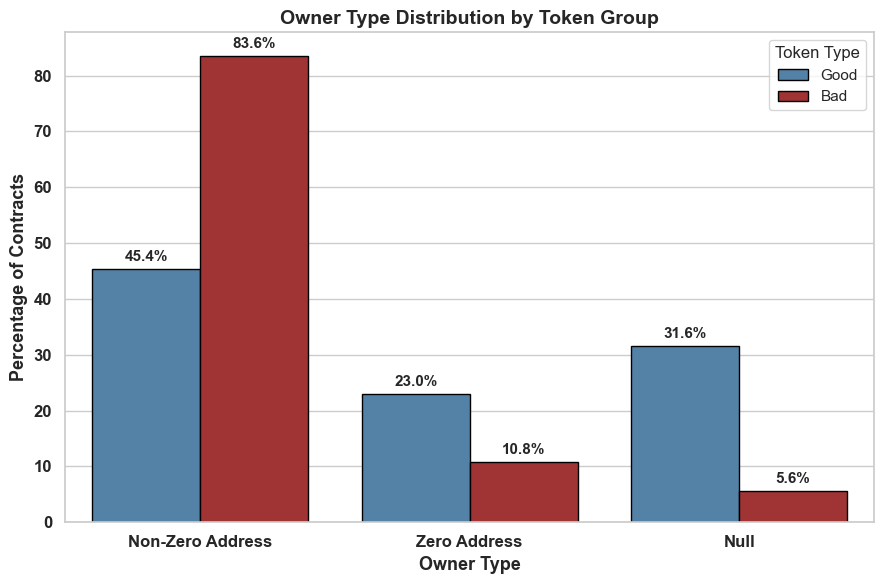

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Owner classification function ---
def classify_owner(owner):
    if pd.isna(owner):
        return 'Null'
    elif owner.lower() == '0x0000000000000000000000000000000000000000':
        return 'Zero Address'
    else:
        return 'Non-Zero Address'

# Apply classification
df_contract_good['owner_type'] = df_contract_good['owner'].apply(classify_owner)
df_contract_bad['owner_type'] = df_contract_bad['owner'].apply(classify_owner)

# Count and normalize
owner_order = ['Non-Zero Address', 'Zero Address', 'Null']
good_counts = df_contract_good['owner_type'].value_counts().reindex(owner_order, fill_value=0)
bad_counts = df_contract_bad['owner_type'].value_counts().reindex(owner_order, fill_value=0)

good_percent = good_counts / good_counts.sum() * 100
bad_percent = bad_counts / bad_counts.sum() * 100

# --- Combine into a single DataFrame ---
combined_df = pd.DataFrame({
    'Owner Type': owner_order * 2,
    'Token Type': ['Good'] * 3 + ['Bad'] * 3,
    'Count': list(good_counts.values) + list(bad_counts.values),
    'Percentage': list(good_percent.values) + list(bad_percent.values)
})

# Create output directory
os.makedirs("charts", exist_ok=True)

# --- Plot ---
plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.barplot(
    data=combined_df,
    x='Owner Type',
    y='Percentage',
    hue='Token Type',
    palette={'Good': 'steelblue', 'Bad': 'firebrick'},
    edgecolor='black'
)

# Annotate with percentage labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width() / 2,
            height + 0.8,
            f"{height:.1f}%",
            ha='center',
            va='bottom',
            fontsize=11,
            fontweight='bold'
        )

# Axis and style
plt.ylabel("Percentage of Contracts", fontsize=13, fontweight='bold')
plt.xlabel("Owner Type", fontsize=13, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.title("Owner Type Distribution by Token Group", fontsize=14, fontweight='bold')
plt.legend(title="Token Type", fontsize=11)
plt.tight_layout()

# Save as PDF
plt.savefig("charts/owner_type_comparison.pdf")
plt.show()


## How many contracts are verified? Have a hidden owner? proxy? sellable? Have a hardcoded owner? have public source code? abi? 

✅ Saved TRUE-only proportional plot to charts\verified_true_only_quality_comparison.pdf


C:\Users\Famiglia\AppData\Local\Temp\ipykernel_15892\33735343.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].apply(to_bool).fillna(True).astype(bool)
C:\Users\Famiglia\AppData\Local\Temp\ipykernel_15892\33735343.py:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].apply(to_bool).fillna(True).astype(bool)
C:\Users\Famiglia\AppData\Local\Temp\ipykernel_15892\33735343.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and s

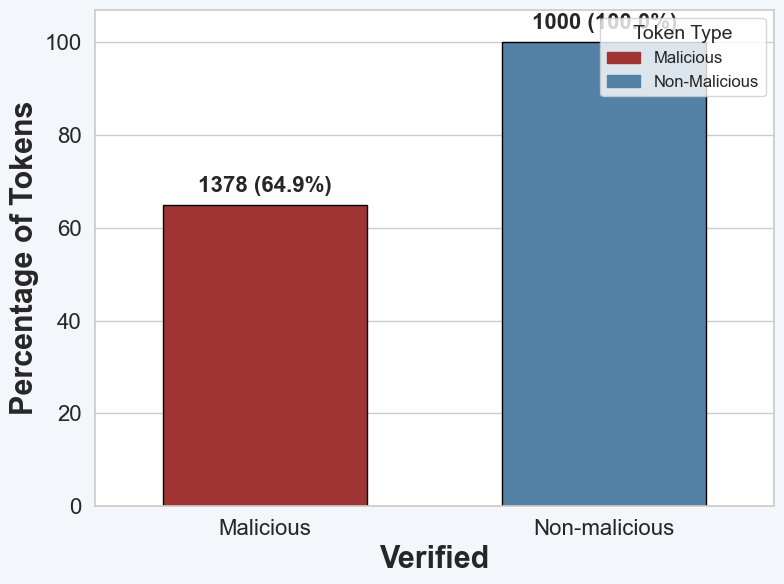

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_15892\33735343.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


✅ Saved TRUE-only proportional plot to charts\is_hidden_owner_true_only_quality_comparison.pdf


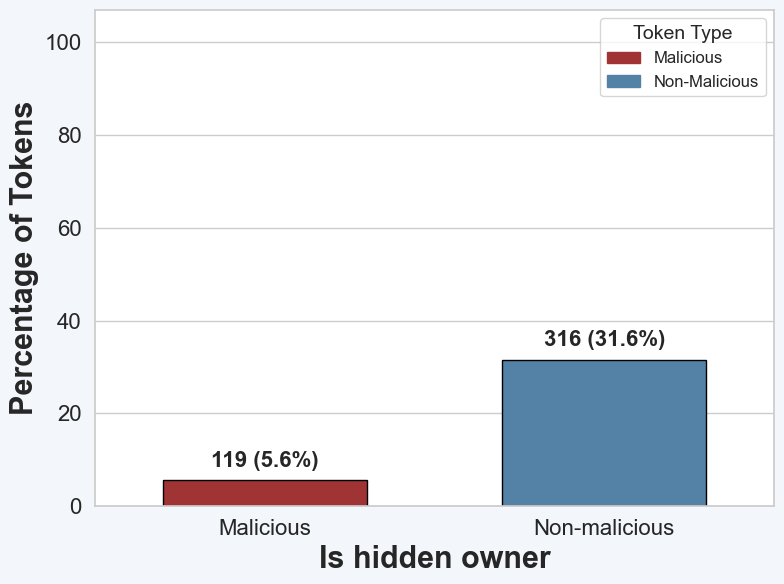

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_15892\33735343.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


✅ Saved TRUE-only proportional plot to charts\is_proxy_true_only_quality_comparison.pdf


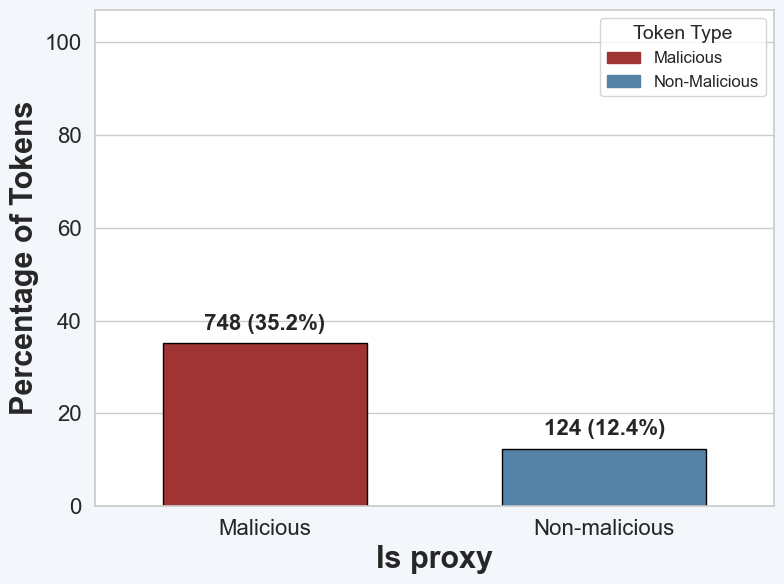

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_15892\33735343.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


✅ Saved TRUE-only proportional plot to charts\is_sellable_true_only_quality_comparison.pdf


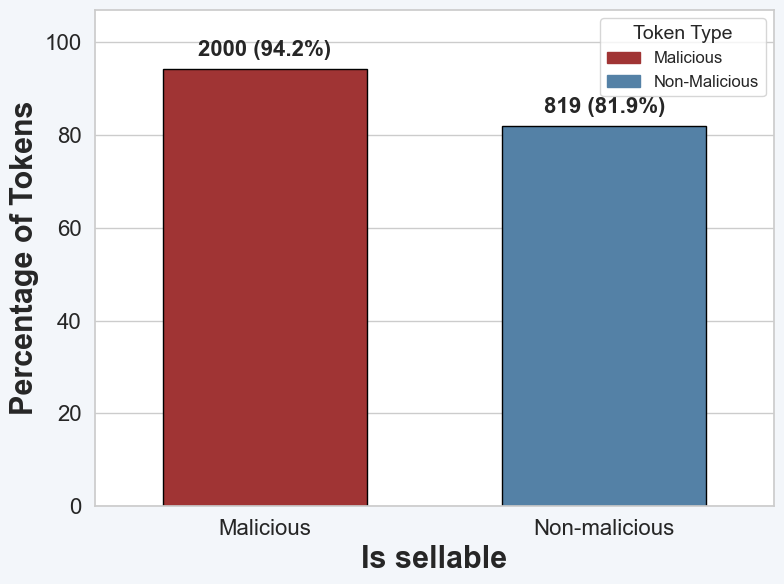

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_15892\33735343.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


✅ Saved TRUE-only proportional plot to charts\is_hardcoded_owner_true_only_quality_comparison.pdf


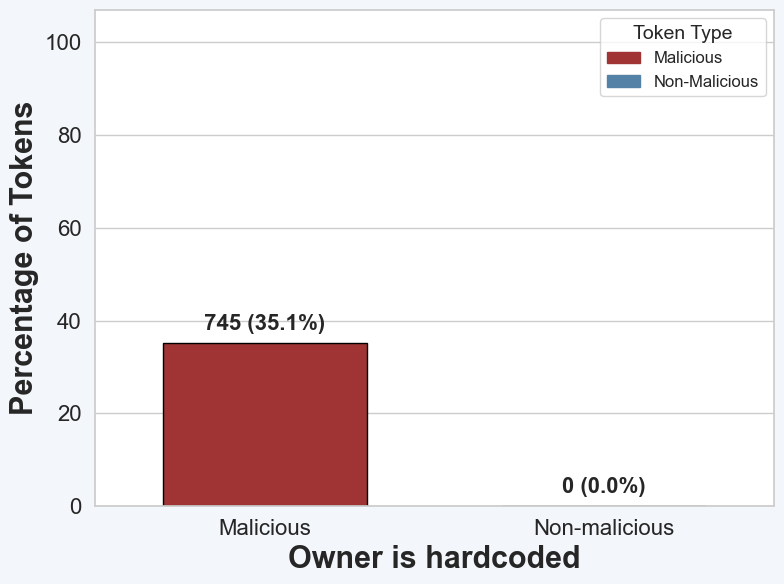

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_15892\33735343.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


✅ Saved TRUE-only proportional plot to charts\has_source_code_true_only_quality_comparison.pdf


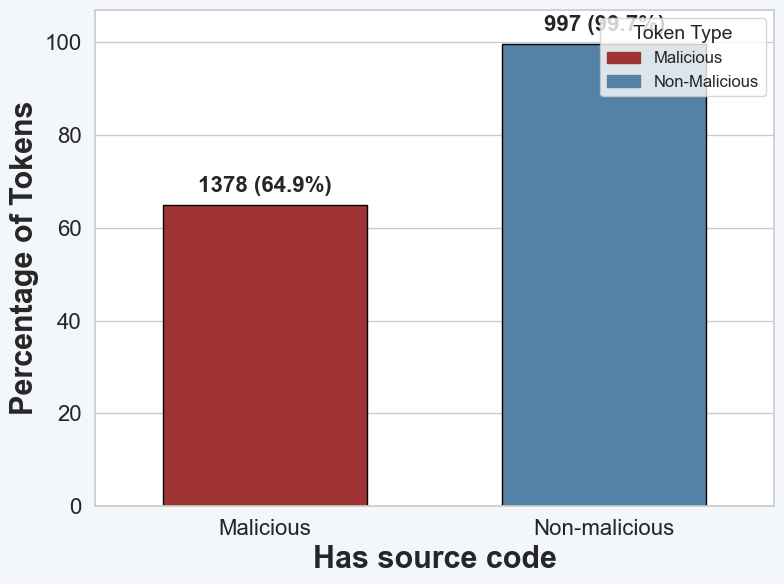

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_15892\33735343.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


✅ Saved TRUE-only proportional plot to charts\has_abi_true_only_quality_comparison.pdf


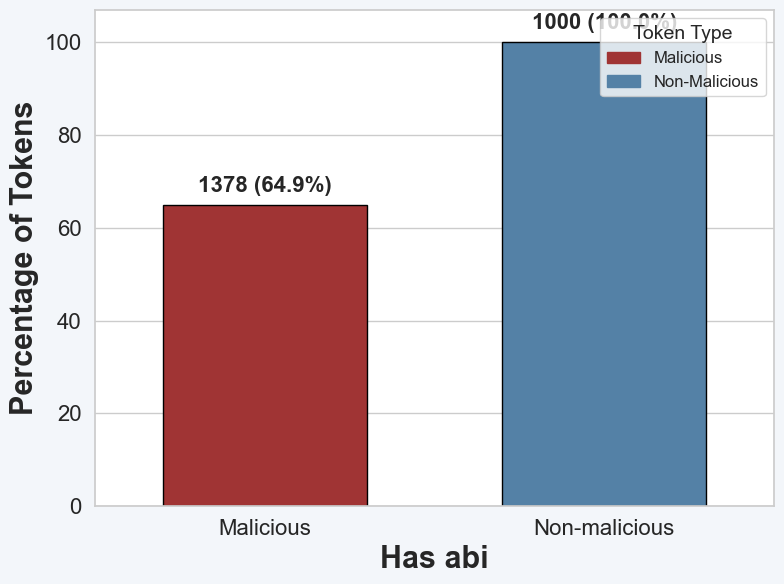

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.patches as mpatches

# Load data
df_contract_bad = pd.read_csv("../csv_outputs/bad_tokens/master_contract.csv")
df_contract_good = pd.read_csv("../csv_outputs/good_tokens/master_contract.csv")

# Add quality column
df_contract_bad['quality'] = 'bad'
df_contract_good['quality'] = 'good'

# Boolean-like columns
bool_cols = ['verified', 'is_hidden_owner', 'is_proxy', 'is_sellable',
             'is_hardcoded_owner', 'has_source_code', 'has_abi']

# Ensure all expected columns exist
for col in bool_cols:
    for df in [df_contract_bad, df_contract_good]:
        if col not in df.columns:
            df[col] = np.nan

# Normalize values to booleans
def to_bool(val):
    val_str = str(val).strip().lower()
    if val_str == 'true':
        return True
    elif val_str == 'false':
        return False
    else:
        return np.nan

for df in [df_contract_bad, df_contract_good]:
    for col in bool_cols:
        df[col] = df[col].apply(to_bool).fillna(True).astype(bool)

# Combine datasets
df_all = pd.concat([df_contract_bad, df_contract_good], ignore_index=True)
df_all['chain'] = df_all['chain'].str.lower()

# Setup output
output_dir = "charts"
os.makedirs(output_dir, exist_ok=True)

# Consistent color palette
color_map = {
    'Malicious': 'firebrick',
    'Non-malicious': 'steelblue'
}


# Apply consistent Seaborn theme
sns.set_theme(style="whitegrid")

# ✅ CHANGED SECTION
for col in bool_cols:
    # Calculate only TRUE counts and percentages
    data = []
    for quality in ['bad', 'good']:
        subset = df_all[df_all['quality'] == quality]
        total = len(subset)
        true_count = subset[col].sum()  # count of True values
        percent_true = (true_count / total) * 100 if total > 0 else 0
        data.append({
            'Quality': 'Malicious' if quality == 'bad' else 'Non-malicious',
            'Count': true_count,
            'Percentage': percent_true
        })

    plot_df = pd.DataFrame(data)

    # ✅ Plot only TRUE values, x-axis = Good/Bad
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(
        data=plot_df,
        x='Quality',
        y='Percentage',
        palette=color_map,
        edgecolor="black",
        width=0.6   # ✅ slightly thinner bars
    )

    # Add annotations
    for i, row in plot_df.iterrows():
        ax.text(
            i,
            row['Percentage'] + 2,
            f"{row['Count']} ({row['Percentage']:.1f}%)",
            ha='center',
            va='bottom',
            fontsize=16,
            fontweight='bold'
        )

    # Labels and formatting
    formatted_col = col.replace("_", " ").capitalize()
    if formatted_col == 'Is hardcoded owner':
        formatted_col = 'Owner is hardcoded'

    ax.set_xlabel(formatted_col, fontsize=22, fontweight='bold')
    ax.set_ylabel("Percentage of Tokens", fontsize=22, fontweight='bold')
    ax.set_ylim(0, 107)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    bar_colors = [bar.get_facecolor() for bar in ax.patches[:2]]  # first two bars: Malicious, Non-Malicious

    malicious_patch = mpatches.Patch(color=bar_colors[0], label='Malicious')
    non_malicious_patch = mpatches.Patch(color=bar_colors[1], label='Non-Malicious')

    ax.legend(handles=[malicious_patch, non_malicious_patch], title='Token Type', title_fontsize=14, fontsize=12, loc='upper right')
    plt.gcf().set_facecolor('#f3f6fa')
    plt.tight_layout()

    # Save chart
    filename = f"{col}_true_only_quality_comparison.pdf"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)
    print(f"✅ Saved TRUE-only proportional plot to {filepath}")

    plt.show()


## Snippets analysis

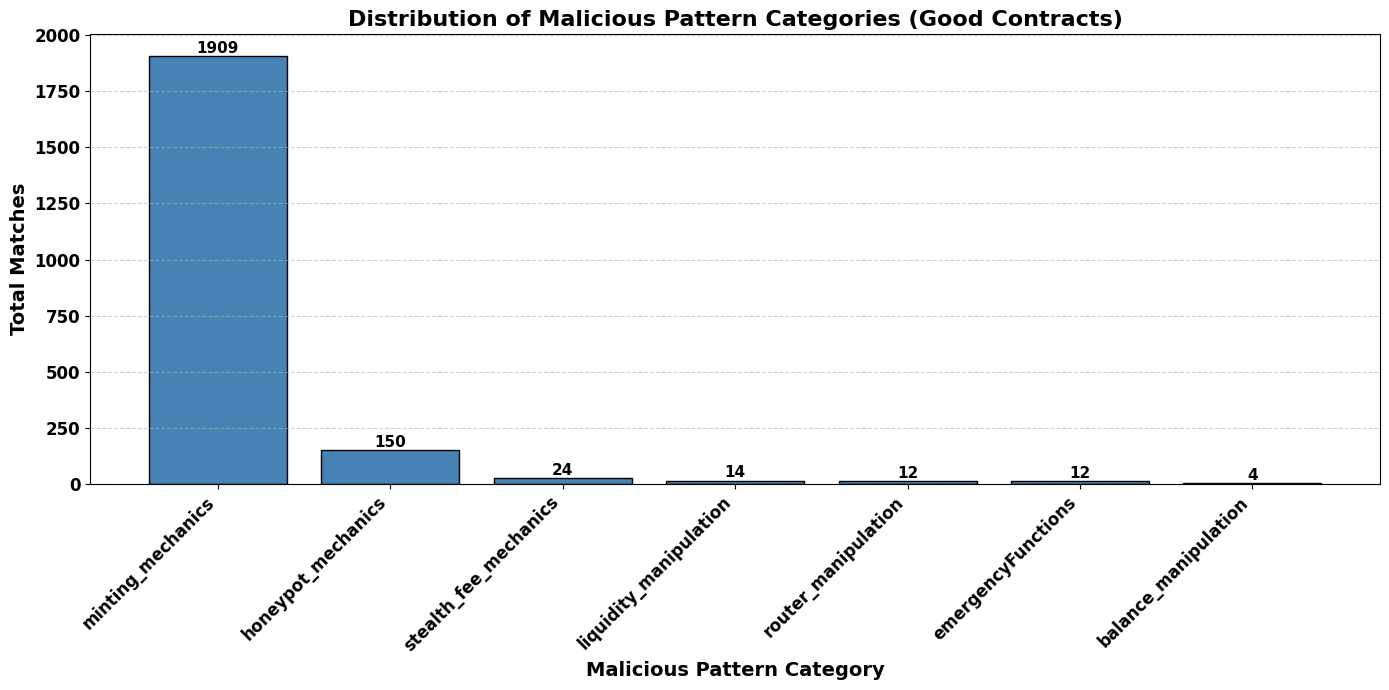

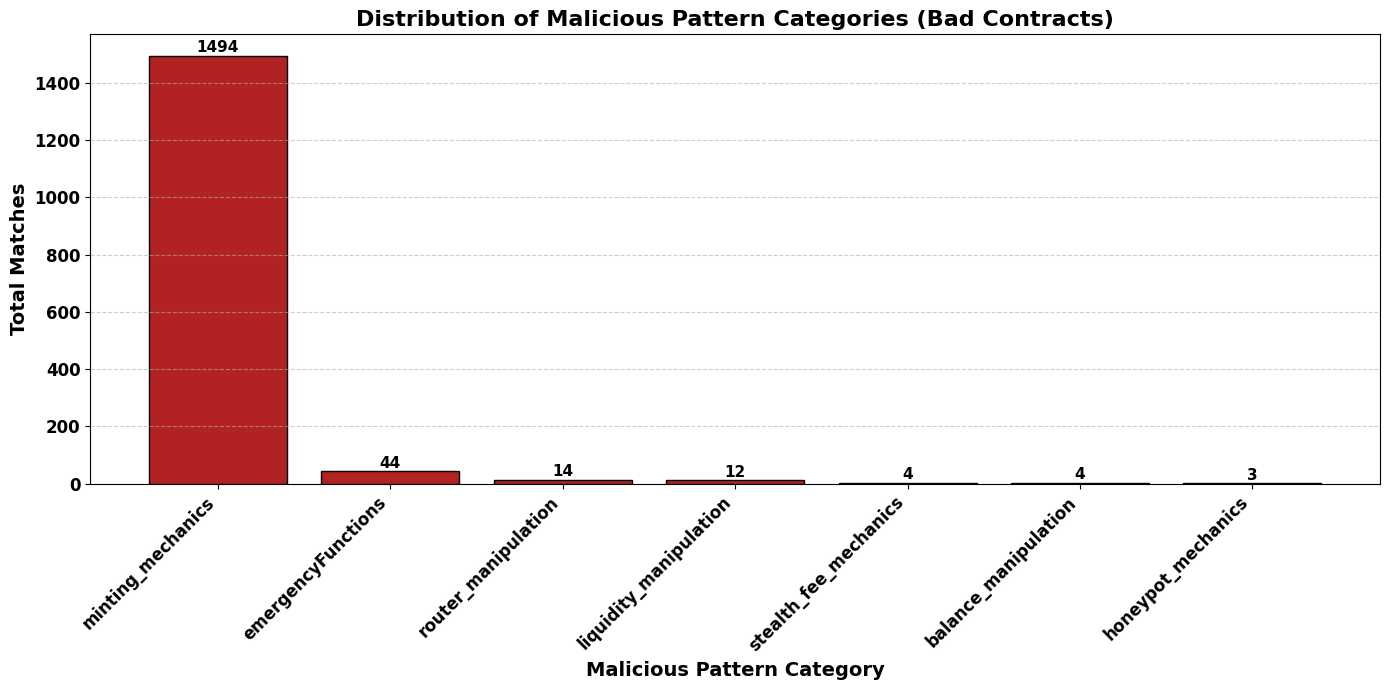

In [6]:
import os
import json
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_pattern_distribution(analysis_folder: str, title_suffix: str = ""):
    """
    Scans a folder of JSON contract analysis files and plots a bar chart 
    showing the total count of each malicious pattern category.

    Parameters:
    - analysis_folder (str): Path to the folder containing JSON files.
    - title_suffix (str): Used to determine coloring and title labeling.
    """
    category_counts = defaultdict(int)

    # Scan all JSON files in folder
    for filename in os.listdir(analysis_folder):
        if filename.endswith('.json'):
            filepath = os.path.join(analysis_folder, filename)

            try:
                with open(filepath, 'r') as f:
                    data = json.load(f)

                # Expected structure
                if 'patterns_found' in data and 'total_matches' in data:
                    for category, content in data['patterns_found'].items():
                        category_counts[category] += content.get('count', 0)

            except Exception as e:
                print(f"Error reading {filename}: {e}")

    if not category_counts:
        print(f"No valid data found in {analysis_folder}")
        return

    # Sorting
    sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
    labels = [cat for cat, _ in sorted_categories]
    counts = [count for _, count in sorted_categories]

    # Set color based on title
    if "bad" in title_suffix.lower():
        bar_color = 'firebrick'
    else:
        bar_color = 'steelblue'

    # Plotting
    plt.figure(figsize=(14, 7))
    bars = plt.bar(labels, counts, color=bar_color, edgecolor='black')
    plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.title(f'Distribution of Malicious Pattern Categories {title_suffix}', fontsize=16, fontweight='bold')
    plt.xlabel('Malicious Pattern Category', fontsize=14, fontweight='bold')
    plt.ylabel('Total Matches', fontsize=14, fontweight='bold')
    plt.tight_layout()

    # Annotate bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height + 1, f'{count}', 
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


bad_analysis_folder = 'C:/Users/Famiglia/Desktop/Amedeo/TESI/Progetto_tesi/thesis/contract_analysis_results/bad_contract_analysis_results'
good_analysis_folder = 'C:/Users/Famiglia/Desktop/Amedeo/TESI/Progetto_tesi/thesis/contract_analysis_results/good_contract_analysis_results'

plot_pattern_distribution(good_analysis_folder, "(Good Contracts)")
plot_pattern_distribution(bad_analysis_folder, "(Bad Contracts)")

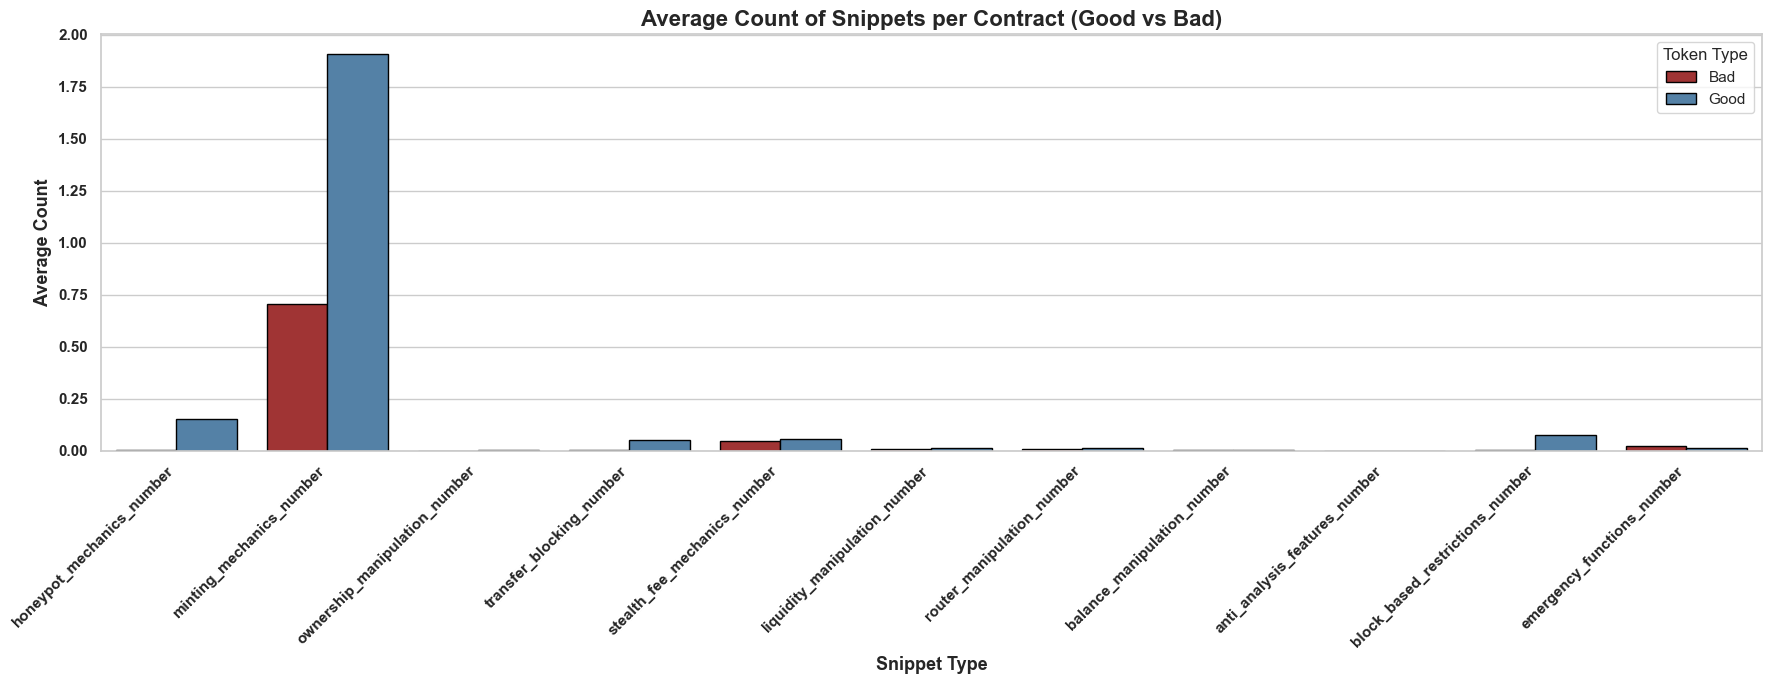

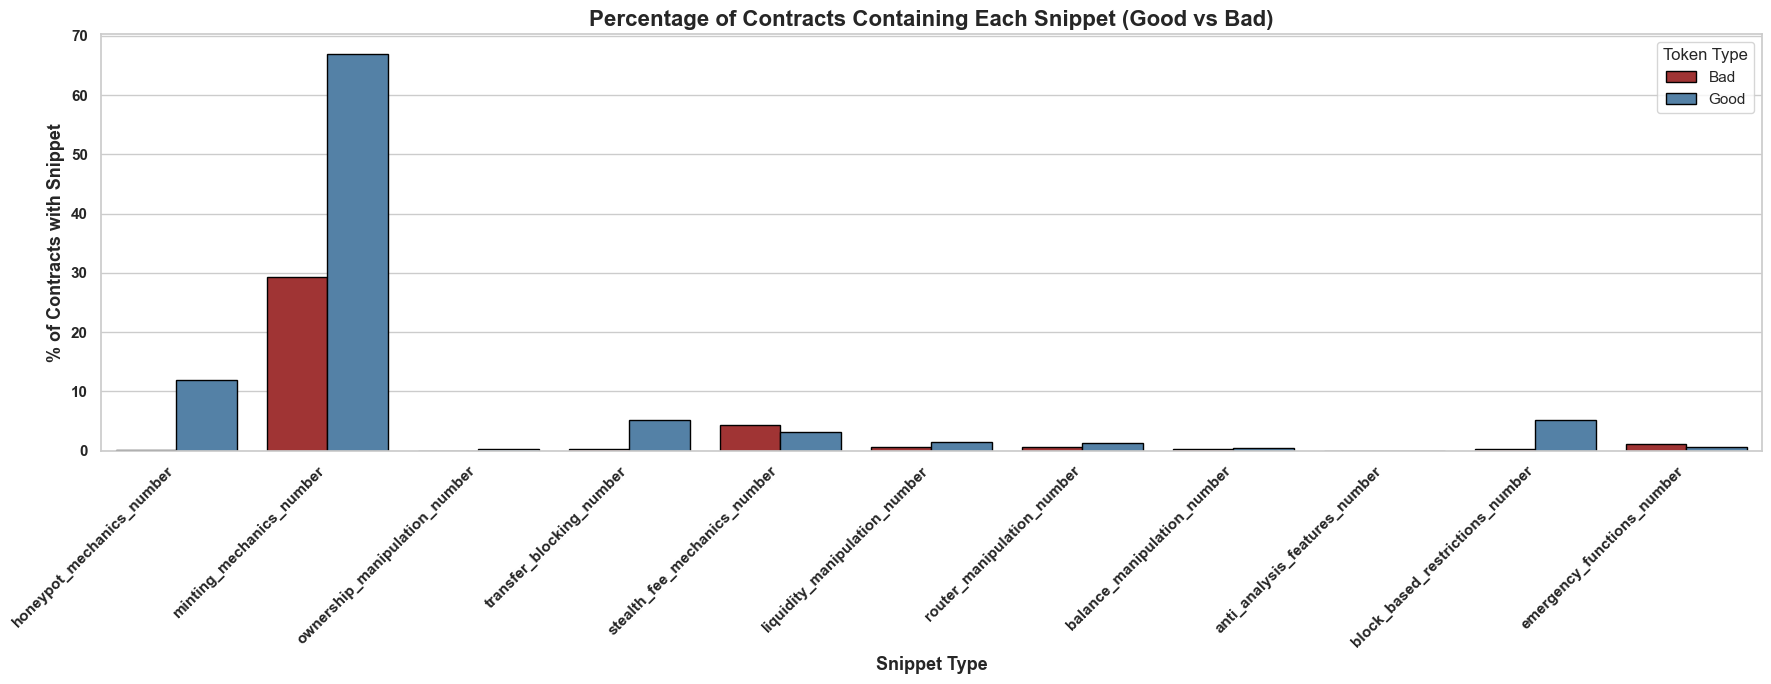

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df_contract_bad = pd.read_csv("../csv_outputs/bad_tokens/master_contract.csv")
df_contract_good = pd.read_csv("../csv_outputs/good_tokens/master_contract.csv")

# Label the datasets
df_contract_bad["quality"] = "Bad"
df_contract_good["quality"] = "Good"

# Combine them
df_all = pd.concat([df_contract_bad, df_contract_good], ignore_index=True)

# Snippet columns
snippet_cols = [
    'honeypot_mechanics_number',
    'minting_mechanics_number',
    'ownership_manipulation_number',
    'transfer_blocking_number',
    'stealth_fee_mechanics_number',
    'liquidity_manipulation_number',
    'router_manipulation_number',
    'balance_manipulation_number',
    'anti_analysis_features_number',
    'block_based_restrictions_number',
    'emergency_functions_number'
]

# Create output directory
os.makedirs("charts", exist_ok=True)

# -------------------------------
# 🔹 OPTION A: Mean Count per Contract
# -------------------------------
mean_counts = df_all.groupby('quality')[snippet_cols].mean().T.reset_index().rename(columns={'index': 'snippet'})
mean_counts_melted = mean_counts.melt(id_vars='snippet', var_name='Token Type', value_name='Average Count')

plt.figure(figsize=(18, 7))
sns.barplot(
    data=mean_counts_melted,
    x='snippet', y='Average Count', hue='Token Type',
    palette=['firebrick', 'steelblue'], edgecolor='black'
)
plt.title("Average Count of Snippets per Contract (Good vs Bad)", fontsize=16, fontweight='bold')
plt.xlabel("Snippet Type", fontsize=13, fontweight='bold')
plt.ylabel("Average Count", fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=11, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.legend(title="Token Type", fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.savefig("charts/avg_snippet_count_per_contract.pdf")
plt.show()

# -------------------------------
# 🔹 OPTION B: Presence Rate (%)
# -------------------------------
presence_df = df_all.copy()
for col in snippet_cols:
    presence_df[col] = presence_df[col].fillna(0)
    presence_df[col] = (presence_df[col] > 0).astype(int)

presence_rate = presence_df.groupby('quality')[snippet_cols].mean().T * 100
presence_rate = presence_rate.reset_index().rename(columns={'index': 'snippet'})
presence_rate_melted = presence_rate.melt(id_vars='snippet', var_name='Token Type', value_name='Presence Rate (%)')

plt.figure(figsize=(18, 7))
sns.barplot(
    data=presence_rate_melted,
    x='snippet', y='Presence Rate (%)', hue='Token Type',
    palette=['firebrick', 'steelblue'], edgecolor='black'
)
plt.title("Percentage of Contracts Containing Each Snippet (Good vs Bad)", fontsize=16, fontweight='bold')
plt.xlabel("Snippet Type", fontsize=13, fontweight='bold')
plt.ylabel("% of Contracts with Snippet", fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=11, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.legend(title="Token Type", fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.savefig("charts/presence_rate_snippets_per_contract.pdf")
plt.show()
